# Fine-Tuning ResNet18 para Reconhecimento de Gestos - INF692

## 1. Configuração de Caminhos e Imports

In [2]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm import tqdm


## 2. Pré-processamento e Carregamento de Dados

In [3]:
data_dir = 'datasets/annotated/INF692_GEST_CLAS_GE.v3i.folder/'
batch_size = 32

mean = [0.485, 0.456, 0.406]  # ImageNet
std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_ds   = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform)
test_ds  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

class_names = train_ds.classes


## 3. Modelo: ResNet18 com Fine-Tuning

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False  # congelar convoluções

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 5 classes
model = model.to(device)


## 4. Treinamento e Validação

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir='Tensorboard/ResNet18')

epochs = 3
best_model_wts = model.state_dict()
best_acc = 0.0
train_loss_list, val_acc_list = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_ds)
    train_loss_list.append(epoch_loss)
    writer.add_scalar('Loss/train', epoch_loss, epoch)

    # validação
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    acc = correct / total
    val_acc_list.append(acc)
    writer.add_scalar('Accuracy/val', acc, epoch)

    if acc > best_acc:
        best_acc = acc
        best_model_wts = model.state_dict()

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'models/resnet18_best.pth')
writer.close()


100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


RuntimeError: Parent directory models does not exist.

## 5. Avaliação no Conjunto de Teste

In [11]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
print(cm)


              precision    recall  f1-score   support

           F       0.96      0.90      0.93        60
           I       0.70      1.00      0.82        84
           L       0.70      0.55      0.62        67
           P       1.00      0.81      0.89        26
           T       0.69      0.56      0.62        71

    accuracy                           0.77       308
   macro avg       0.81      0.76      0.78       308
weighted avg       0.77      0.77      0.76       308

[[54  0  0  0  6]
 [ 0 84  0  0  0]
 [ 2 16 37  0 12]
 [ 0  5  0 21  0]
 [ 0 15 16  0 40]]


## 6. Visualização dos Resultados

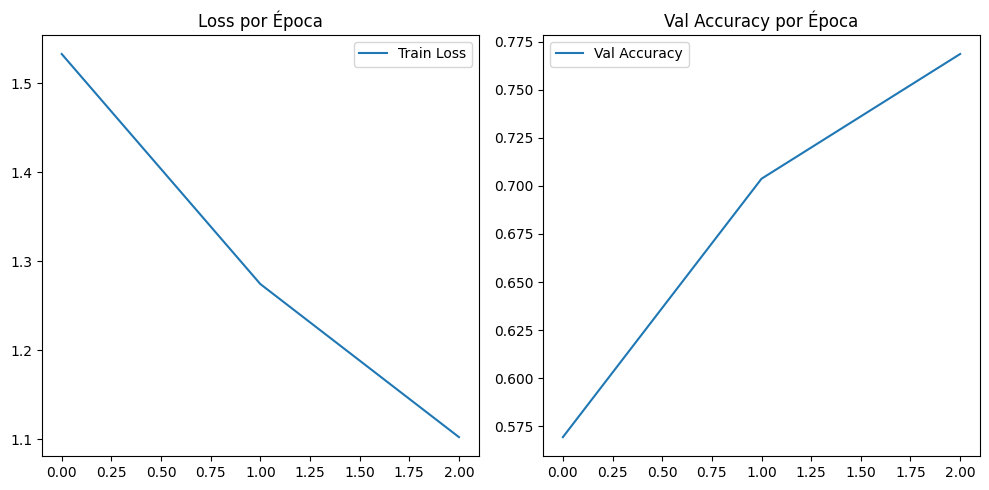

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.title('Loss por Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_list, label='Val Accuracy')
plt.title('Val Accuracy por Época')
plt.legend()
plt.tight_layout()
plt.show()
